In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time

from library.evaluation import ConfusionMatrix

dataset_name = "Phemernr2-RNTF"
unique_name = "RoBERTa_Finetuned_with_TopTermsVectors"
tvt_set = "tvt2_3"

bigram_limit = 750

In [2]:
vectors = np.loadtxt("../../data/processed/vectors/Phemernr2_RoBERTa_base_finetuned_vectors.txt", delimiter=",")
vectors.shape

(6425, 768)

In [3]:
data = pd.read_csv("../../data/processed/phemernr2_dataset_with_tvt.csv", lineterminator="\n")
data.head()

,tweet_id,tweet_text,label,label2,topic,tvt,cv_fold,tt,tvt2,tvt2_1,tvt2_2,tvt2_3
0,552833795142209536,The East London Mosque would like to offer its...,non-rumours,non-rumours,charliehebdo-all-rnr-threads,test,2,test,validation,training,validation,training
1,580318210609696769,BREAKING - A Germanwings Airbus A320 plane rep...,rumours,true,germanwings-crash-all-rnr-threads,training,3,training,training,validation,training,training
2,552798891994009601,Reports that two of the dead in the #CharlieHe...,rumours,true,charliehebdo-all-rnr-threads,test,2,test,training,validation,validation,training
3,576790814942236672,After #Putin disappeared Russian TV no longer ...,non-rumours,non-rumours,putinmissing-all-rnr-threads,test,2,test,training,training,training,training
4,499678822598340608,Saw #Ferguson for myself. #justiceformichaelbr...,non-rumours,non-rumours,ferguson-all-rnr-threads,training,3,training,training,validation,training,training


In [4]:
label_type = "label2"
labels_str = data[label_type].unique().tolist()
labels_str

['non-rumours', 'true', 'unverified', 'false']

In [5]:
labels = []
for i, d in data.iterrows():
    lab = labels_str.index(d[label_type])
    labels.append(lab)
labels[:10]

[0, 1, 1, 0, 0, 0, 0, 2, 0, 0]

In [6]:
bigram_vector_base = []
with open("../../data/processed/phemernr2-multiclass_best_terms.txt", "r") as f:
    for t in f.readlines():
        bigram_vector_base.append(t)
        
bigram_vector_base = bigram_vector_base[:bigram_limit]
len(bigram_vector_base)

750

In [7]:
import string
import nltk
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer(reduce_len=True)


def text2bigrams(text):
    bigrams = tokenizer.tokenize(text.encode('ascii', 'ignore').decode('utf8'))
    bigrams = [t for t in bigrams if t not in string.punctuation]
    bigrams = [t for t in bigrams if t not in ['URL', '‘', '’']]
    
    bigrams = nltk.bigrams(bigrams)
    bigrams = map(' '.join, bigrams)
    bigrams = [bgr for bgr in bigrams]
    
    return bigrams


def bigrams_vectors_generation(texts):
    bigram_vectors = []
    for text in texts:
        bigrams = text2bigrams(text)

        init_vec = [0.0 for _ in range(len(bigram_vector_base) + 1)]
        for bgr in bigrams:
            if bgr in bigram_vector_base:
                idx = bigram_vector_base.index(bgr)
                init_vec[idx] = 1.0
            else:
                init_vec[-1] = 1.0
        bigram_vectors.append(init_vec)
    
    return bigram_vectors

In [8]:
texts = data['tweet_text'].tolist()
bigram_vectors = bigrams_vectors_generation(texts)

vectors = np.concatenate([vectors, bigram_vectors], axis=1)
vectors = vectors.reshape(vectors.shape[0], vectors.shape[1], 1)
vectors.shape

(6425, 1519, 1)

In [9]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d[tvt_set] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d[tvt_set] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d[tvt_set] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d[tvt_set] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d[tvt_set] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d[tvt_set] == 'testting'])

In [10]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(4339, 1519, 1)
(1456, 1519, 1)
(630, 1519, 1)
(4339,)
(1456,)
(630,)


In [11]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class NNClassifier(nn.Module):
    def __init__(self,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        beta1: float = 0.5,
        lr: float = 0.0002,
        device: str = None
    ):
        super(NNClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(n_input, 512, 1, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 128, 1, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=1, stride=2),
            nn.Flatten(),
            nn.Linear(128, n_output),
            nn.Sigmoid()
        )
        self.criterion = criterion()
        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device
        
        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999))

    def forward(self, input):
        return self.model(input)
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        binary: bool = False,
        saves: str = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        best_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            correct = 0
            total = 0
            for batch_idx, (inputs, targets) in enumerate(trainloader):
                self.model.zero_grad()
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)

                try:
                    loss = self.criterion(outputs, targets)
                except Exception:
                    loss = self.criterion(outputs, targets.long())

                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                total += targets.size(0)
                
            train_losses.append(train_loss)

            self.model.eval()
            test_loss = 0
            test_acc = 0
            with torch.no_grad():
                inputs, targets = test_x.to(self.device), test_y.to(self.device)
                outputs = self.model(inputs)
                
                try:
                    loss = self.criterion(outputs, targets)
                except Exception:
                    loss = self.criterion(outputs, targets.long())

                test_loss += loss.item()
                
                preds = self.predict(test_x, binary=binary)
                if binary:
                    preds = np.array([p[0] for p in preds.cpu().numpy()])
                    label_target = np.array([v[0] for v in test_y])
                else:
                    preds = np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds.cpu().numpy()])
                    label_target = np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_y])
                
                conf_mat = ConfusionMatrix(
                    labels=label_target,
                    predictions=preds,
                    binary=binary
                )
                conf_mat.evaluate(logs=False)
                test_acc = conf_mat.accuracy

            test_losses.append(test_loss)
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train Loss : {train_loss}, Test Loss : {test_loss}")

            # Save checkpoint.
#             if saves and test_loss < best_loss:
#                 print(f"Saving after new best loss : {test_loss}")
#                 best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/{saves}.pth")
            
            if epoch >= n_iter:
                break

        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)

        ax2.plot([i for i in range(len(train_losses))], train_losses, c='b', marker="o", label='Train Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, c='r', marker="o", label='Test Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_xlim(0, len(train_losses))
        ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Loss over time (epoch)")
        ax2.legend(loc='lower right')

        plt.show()
    
    def predict(self, input_x, binary=False):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

Multiclass Classification using 4-Layer Linear Network
Using cuda
Saving after new best accuracy : 84.203
Saving after new best accuracy : 84.272
Saving after new best accuracy : 84.341
-- Epoch 50, Train Loss : 6.723447263240814, Test Loss : 0.8952113389968872
Saving after new best accuracy : 84.409
Saving after new best accuracy : 84.478
-- Epoch 100, Train Loss : 6.716797769069672, Test Loss : 0.8969417810440063
-- Epoch 150, Train Loss : 6.714404582977295, Test Loss : 0.8985151648521423
-- Epoch 200, Train Loss : 6.714053630828857, Test Loss : 0.8989081978797913
-- Epoch 250, Train Loss : 6.7138537764549255, Test Loss : 0.8989806175231934
-- Epoch 300, Train Loss : 6.71366673707962, Test Loss : 0.8989604711532593
Saving after new best accuracy : 84.547
-- Epoch 350, Train Loss : 6.713586151599884, Test Loss : 0.8987277746200562
-- Epoch 400, Train Loss : 6.713533282279968, Test Loss : 0.8986003994941711
-- Epoch 450, Train Loss : 6.713540196418762, Test Loss : 0.8985135555267334
Sa

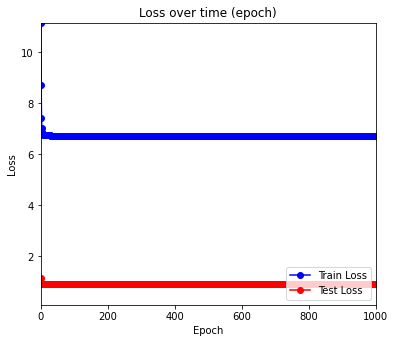

Exec Time : 177.03 seconds

Validation Set
Predictions : torch.Size([1456])
1456 vs 1456
Multi Class Evaluation

Class non-rumours Evaluation
- Precision : 89.574 %
- Recall : 93.142 %
- F1 : 0.91323

Class true Evaluation
- Precision : 76.955 %
- Recall : 73.333 %
- F1 : 0.751

Class unverified Evaluation
- Precision : 65.278 %
- Recall : 61.842 %
- F1 : 0.63514

Class false Evaluation
- Precision : 84.496 %
- Recall : 75.172 %
- F1 : 0.79562

Combined Evaluation
- Accuracy : 84.615 %
- Precision : 79.076 %
- Recall : 75.872 %
- F1 : 0.77441

- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,true,,,unverified,,,false,,,
Phemernr2-RNTF_4LayerNet_RoBERTa_Finetuned_with_TopTermsVectors Validation, 84.615, 79.076, 75.872, 0.77441, 89.574, 93.142, 0.91323, 76.955, 73.333, 0.751, 65.278, 61.842, 0.63514, 84.496, 75.172, 0.79562, 

Test Set
Predictions : torch.Size([630])
630 vs 630
Multi Class Evaluation

Class non-rumours Evaluation
- Precision : 89.786 %
- Recall : 94.737 %


In [12]:
print("Multiclass Classification using 4-Layer Linear Network")
binary = False

start = time.time()
model_name = f"{dataset_name}_4LayerNet_{unique_name}"
model = NNClassifier(train_vectors.shape[1], n_output=4, criterion=nn.CrossEntropyLoss)
model.train_eval(torch.Tensor(train_vectors),
                torch.Tensor(train_labels),
                torch.Tensor(val_vectors),
                torch.Tensor(val_labels),
                binary=binary,
                saves=model_name,
                n_iter=1000,
                batch_size=512)
print(f"Exec Time : {round(time.time() - start, 2)} seconds")

model.load_pretrained(f"../../data/models/{model_name}.pth")

print("\nValidation Set")
preds = model.predict(val_vectors, binary=binary)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()
if binary:
    preds = np.array([p[0] for p in preds])
    label_target = np.array([v[0] for v in val_labels])
else:
    preds = np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds])
    label_target = np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in val_labels])

conf_mat = ConfusionMatrix(
    labels=label_target,
    predictions=preds,
    binary=binary,
    model_name=f"{model_name} Validation"
)
conf_mat.evaluate(classes=labels_str)

print("\nTest Set")
preds = model.predict(test_vectors, binary=binary)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()
if binary:
    preds = np.array([p[0] for p in preds])
    label_target = np.array([v[0] for v in test_labels])
else:
    preds = np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds])
    label_target = np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_labels])

conf_mat = ConfusionMatrix(
    labels=label_target,
    predictions=preds,
    binary=binary,
    model_name=f"{model_name} Test"
)
conf_mat.evaluate(classes=labels_str)